Coefficient of determination: 0.733


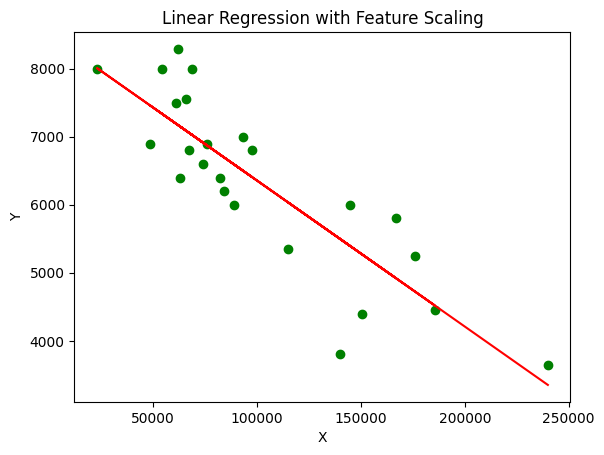

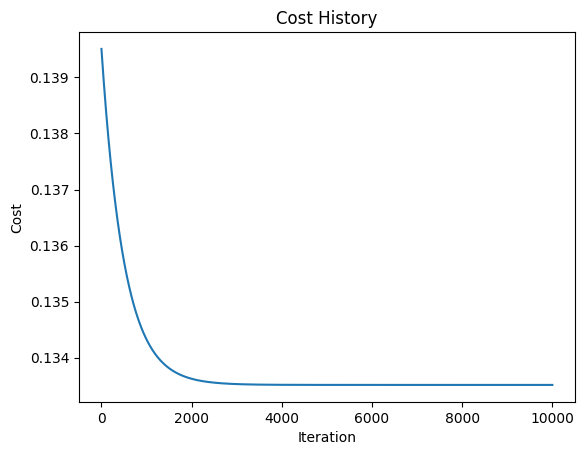

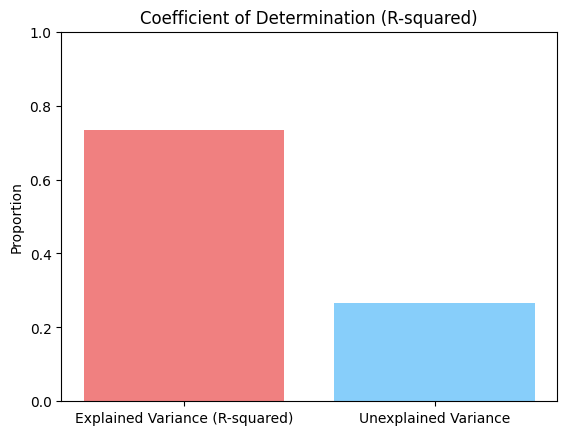

In [15]:
import numpy as np
import csv
import matplotlib.pyplot as plt

def feature_scaling(X, y):
    # average number of kilometers
    # Calculate mean along the rows (axis=0)
    mean_X = np.mean(X, axis=0)
    # Standard deviation => the amount of variability or dispersion in the data. 
    # A higher standard deviation means the values are more spread out from the mean.
    std_X = np.std(X, axis=0)
    
    # Check for zero standard deviation to avoid division by zero
    std_X[std_X == 0] = 1.0

    #feature scaling => so that scaled value has a mean of 0 and a standard deviation of 1
    # the mean of x becomes 0 in x_scaled
    X_scaled = (X - mean_X) / std_X
    
    mean_y = np.mean(y)
    std_y = np.std(y)
    
    # Check for zero standard deviation to avoid division by zero
    std_y = 1.0 if std_y == 0 else std_y
    
    y_scaled = (y - mean_y) / std_y
    
    return X_scaled, y_scaled, mean_X, std_X, mean_y, std_y

def model(X, theta):
    return X.dot(theta)

def cost_function(X, y, theta):
    m = len(y)
    return 1/(2*m) * np.sum((model(X, theta) - y)**2)

def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

def gradient_descent(X, y, theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta)
        cost_history[i] = cost_function(X, y, theta)
    return theta, cost_history

# Coefficient of determination (the closest to 1 the better our) - methode de moindre carre
def coef_determination(y, pred):
    mean_y = np.mean(y)
    u = ((y - pred)**2).sum()
    v = ((y - mean_y)**2).sum()
    return 1 - (u / v)

def plot_results(X_vector, Y_vector, predictions):
    plt.scatter(X_vector, Y_vector, c='g')
    plt.plot(X_vector, predictions, c='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Linear Regression with Feature Scaling')
    plt.show()

def plot_cost_history(cost_history):
    plt.plot(range(len(cost_history)), cost_history)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost History')
    plt.show()

# R-squared represents the proportion of the dependent variable's variance 
# that is explained by the independent variable(s)
def plot_coefficient_of_determination(r_squared):
    labels = ['Explained Variance (R-squared)', 'Unexplained Variance']
    values = [r_squared, 1 - r_squared]
    colors = ['lightcoral', 'lightskyblue']

    plt.bar(labels, values, color=colors)
    plt.ylabel('Proportion')
    plt.title('Coefficient of Determination (R-squared)')
    plt.ylim(0, 1)  # Set y-axis limits to represent proportions
    plt.show()
    
def main():
    try:
        # Load the dataset
        dataset = []
        with open('data.csv', 'r') as file:
            reader = csv.reader(file)
            header = next(reader)
            if not header:
                raise ValueError("Error: The CSV file is empty.")
            
            for row in reader:
                if not row:
                    raise ValueError("Error: The CSV file contains empty rows.")
                
                # Ensure the row contains valid numbers
                try:
                    dataset.append([float(row[0]), float(row[1])])
                except ValueError:
                    raise ValueError("Error: The CSV file contains non-numeric values.")

        if not dataset:
            raise ValueError("Error: No valid data found in the CSV file.")

        data_array = np.array(dataset)

        X_vector = data_array[:, 0]
        Ones_vector = np.ones(X_vector.shape)
        X_matrix = np.column_stack((X_vector, Ones_vector))
        Y_vector = data_array[:, 1]
        Y_vector = Y_vector.reshape(Y_vector.shape[0], 1)

        # Feature scaling
        X_scaled, Y_scaled, mean_X, std_X, mean_Y, std_Y = feature_scaling(X_matrix, Y_vector)

        # Initialize random theta
        theta = np.random.randn(2, 1)

        # Run gradient descent
        final_theta, cost_history = gradient_descent(X_scaled, Y_scaled, theta, learning_rate=0.001, n_iterations=10000)

        # Make predictions
        predictions_scaled = model(X_scaled, final_theta)
        predictions = predictions_scaled * std_Y + mean_Y

        # Coefficient of determination
        r_squared = coef_determination(Y_vector, predictions)
        rounded_r_squared = round(r_squared, 4)
        print(f"Coefficient of determination: {rounded_r_squared}")
        
        # Plotting
        plot_results(X_vector, Y_vector, predictions)
        plot_cost_history(cost_history)
        plot_coefficient_of_determination(rounded_r_squared)
        

        # Save the model
        with open('linear_regression_model.txt', 'w') as file:
            for val in final_theta:
                file.write(f"{val[0]}\n")
            file.write(f"{mean_X[0]}\n")
            file.write(f"{std_X[0]}\n")
            file.write(f"{mean_Y}\n")
            file.write(f"{std_Y}\n")

    except FileNotFoundError:
        print("Error: The file 'data.csv' was not found.")
    except ValueError as ve:
        print(f"Error: {ve}")

if __name__ == "__main__":
    main()
    

In [20]:
import numpy as np

def load_model(file_path='linear_regression_model.txt'):
    # Load the trained model
    with open(file_path, 'r') as file:
        final_theta = np.array([[float(file.readline().strip())] for _ in range(2)])
        mean_X = float(file.readline().strip())
        std_X = float(file.readline().strip())
        mean_Y = float(file.readline().strip())
        std_Y = float(file.readline().strip())
    return final_theta, mean_X, std_X, mean_Y, std_Y

def predict_price(km, final_theta, mean_X, std_X, mean_Y, std_Y):
    # Validate input
    if km < 0:
        raise ValueError("Hey, a car with less than 0 km doesn't exist!")
    elif km > 400000:
        raise ValueError("Whoa, with this many kilometers, our crystal ball is a bit cloudy")

    # Scale the km value using the same scaling parameters used in training
    scaled_km = (km - mean_X) / std_X
    scaled_km_with_bias = np.array([[scaled_km, 1]])
    price = np.dot(scaled_km_with_bias, final_theta)
    
    # Rescale the predicted price to the original scale, extract scalar value, and round it
    estimated_price = round(np.squeeze(price) * std_Y + mean_Y)
    return estimated_price

def main():
    try:
        # Example usage
        final_theta, mean_X, std_X, mean_Y, std_Y = load_model()
        km = float(input("Enter the km of the car: "))
        estimated_price = predict_price(km, final_theta, mean_X, std_X, mean_Y, std_Y)
        print(f"Estimated price for {km} km: {estimated_price}")
    except ValueError as ve:
        print(ve)

if __name__ == "__main__":
    main()


Enter the km of the car:  500000000000000000000000000000000000000


Whoa, with this many kilometers, our crystal ball is a bit cloudy
